# TNG100 MaNGA Survey

This notebook provides a procedure for adding MaNGA realism to simulated galaxies from the TNG simulations using the `RealSim-IFS` code.

In [1]:
import os,sys,time,random
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
import numpy as np
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
from shutil import copy as cp
from copy import copy
from glob import glob
import RealSim_IFS
import warnings
from time import process_time 
import multiprocessing as mp
from astropy.cosmology import FlatLambdaCDM
from astropy.convolution import convolve
import pymysql 
import gc

rc('font',**{'family':'serif'})
rc('text', usetex=True)

If using a cluster, best to be working locally as much as possible.

In [2]:
if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
    wdir = os.environ['SLURM_TMPDIR']
    os.chdir(wdir)
    print(os.getcwd())

/localscratch/bottrell.40531742.0


### Plot a few examples

Idealized kinematics of a few TNG100 galaxies

6.025480508804321


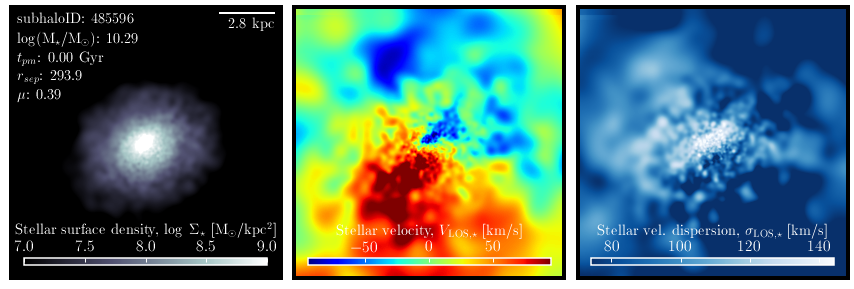

In [36]:
def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=16)
    cbar.set_label(label, color=colour, size=15)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def plot(maps,header,
         show_info=True,show_colorbars=True,factor=1,
         vmins=None,vmaxs=None,use_vmaxima=False,return_vmaxima=False):
    
    fov_kpc = header['FOV_KPC']
    npixels = header['NPIXEL']
    subhaloID = header['SUBID']
    camera = header['AXIS']
    ptype = header['PARTTYPE']
    snapID = header['SNAPNUM']
    kpc_per_pixel = fov_kpc/npixels
    mask = np.log10(maps[0])
    
    # get ancillary data from database
    cnf_path='/home/bottrell/.mysql/lauca.cnf'
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell',
                         database='IllustrisTNG100_1',
                         read_default_file=cnf_path)
    c = db.cursor()
    dbcmd = ['SELECT Mstar,Tpostmerger,rsep,MassRatio',
             'FROM Environment',
             'WHERE DB_ID="{}_{}"'.format(snapID,subhaloID)]
    c.execute(' '.join(dbcmd))
    data = np.array(c.fetchall())[0]
    c.close()
    db.close()
    mstar=data[0]
    tpost=data[1]
    rsep=data[2]
    mu=data[3]
    if rsep>300: rsep=999

    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)
        
    if vmaxs is None and vmins is None:
        vmaxs = np.zeros(3)
        vmins = np.zeros(3)
    
    # Stellar Surface Density
    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    if use_vmaxima:
        m0min=vmins[0]
        m0max=vmaxs[0]
    else:
        m0min = np.around((4.5-np.log10(kpc_per_pixel**2))*2)/2
        m0max = np.around(np.nanpercentile(np.log10(maps[0]*factor/kpc_per_pixel**2),99.9)*2)/2
        vmins[0] = m0min
        vmaxs[0] = m0max
    im = ax.imshow(np.log10(maps[0]*factor/kpc_per_pixel**2),vmin=m0min,vmax=m0max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}$/kpc$^2$]'
    if show_colorbars:
        add_colorbar(im,ax,label,colour=cbar_colour)
    
    if show_info:
        txts = [r'subhaloID: {} \\'.format(subhaloID),
                r'$\log($M$_{{\star}}/$M$_{{\odot}}$): {:0.2f} \\'.format(mstar),
                r'$t_{{pm}}$: {:0.2f} Gyr \\'.format(tpost),
                r'$r_{{sep}}$: {:.1f} \\'.format(rsep),
                r'$\mu$: {:.2f}'.format(mu)]
        offset = 0.0
        for txt in txts:
            ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
            offset+=0.07
        ax.axhline(y=0.975*maps.shape[1],xmax=0.975,xmin=0.775,c='white',lw=2)
        ax.text(0.975,0.96,'{:.1f} kpc'.format(fov_kpc/10),ha='right',va='top',color='white',size=15,transform=ax.transAxes)

    # Velocity
    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    if use_vmaxima:
        m1min=vmins[1]
        m1max=vmaxs[1]
    else:
        vmap = copy(maps[1])
        vmap[mask<5]=np.nan
        m1min = np.abs(np.nanpercentile(vmap[192:-192,192:-192],1))
        m1max = np.abs(np.nanpercentile(vmap[192:-192,192:-192],99))
        m1max = (m1min+m1max)/2
        m1min = -m1max
        vmins[1] = m1min
        vmaxs[1] = m1max
    im = ax.imshow(maps[1],vmin=m1min,vmax=m1max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    if show_colorbars:
        add_colorbar(im,ax,label,colour=cbar_colour)

    # Velocity dispersion
    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    if use_vmaxima:
        m2min=vmins[2]
        m2max=vmaxs[2]
    else:
        smap = copy(maps[2])
        smap[mask<5]=np.nan
        m2min = np.abs(np.nanpercentile(smap[192:-192,192:-192],1))
        m2max = np.abs(np.nanpercentile(smap[192:-192,192:-192],99))
        vmins[2] = m2min
        vmaxs[2] = m2max
    im = ax.imshow(maps[2],vmin=m2min,vmax=m2max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    if show_colorbars:
        add_colorbar(im,ax,label,colour=cbar_colour)
    if return_vmaxima:
        return fig,axarr,vmins,vmaxs
    else:
        return fig,axarr


def main(n_samples,seed=0):
    
    random.seed(seed)
    
    losvd_dir = '/project/6020225/bottrell/share/mhani/LOSVD'
    local_dir = os.getcwd()
    
    filenames = list(sorted(glob('{}/*stars_i*__32.fits'.format(losvd_dir))))
    filenames = random.sample(filenames,n_samples)
    
    for filename in filenames:
        start = time.time()
        localfile = filename.replace(losvd_dir,wdir)
        cp(filename,localfile)
        maps = RealSim_IFS.Generate_Maps_From_File(localfile)
        header = fits.getheader(localfile)
        if os.access(localfile,0):os.remove(localfile)
        print(time.time()-start)
        
        plot(maps,header)
    
if __name__ == '__main__':
    n_samples=1
    main(n_samples,seed=293131919281)

# Selection function

We want a similar redshift distribution to the MaNGA sample. But we can also generate synthetic data of each simulated galaxy at multiple redshifts. Therefore, each galaxy can be observed as though it was in the primary sample, secondary sample. Instead of splitting into primary and secondary, however, I could pick 5 redshifts for each galaxy so that they may be observed with each of the 5 IFU designs out to $1.5 R_e$ and then 5 more to be observed out to $2.5 R_e$. Below, I plot the selection function for MaNGA galaxies based on their absolute magnitudes and redshifts.

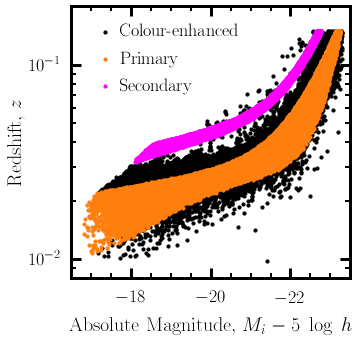

In [5]:
from matplotlib import rc
#rc('text', usetex=True)

rc('font',**{'family':'serif'})
rc('text', usetex=True)

targetcat_name = 'MaNGA_targets_extNSA_tiled_ancillary.fits'
if not os.access(targetcat_name,0):
    targetcat_url = 'https://data.sdss.org/sas/dr16/manga/target/v1_2_27/{}'.format(targetcat_name)
    os.system('wget {}'.format(targetcat_url))

data = fits.getdata(targetcat_name)
bitmask = data['MANGA_TARGET1']
pri_mask = (bitmask & 1024)!=0
sec_mask = (bitmask & 2048)!=0
cen_mask = (bitmask & 4096)!=0

# queued to be observed
obsflag = data['OBSFLAG']==1
# selected by random generator
ranflag = data['RANFLAG']==1

pri = data[pri_mask]
sec = data[sec_mask]
cen = data[cen_mask]

fig,ax = plt.subplots(figsize=(5,5))
ax.minorticks_on()
ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1)
ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
ax.tick_params(axis='both',which='major',pad=10)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
    
ax.scatter(cen['NSA_ELPETRO_ABSMAG'][:,5],cen['NSA_Z'],s=10,c='black',label='Colour-enhanced')
ax.scatter(pri['NSA_ELPETRO_ABSMAG'][:,5],pri['NSA_Z'],s=10,c='C1',label='Primary')
ax.scatter(sec['NSA_ELPETRO_ABSMAG'][:,5],sec['NSA_Z'],s=10,c='magenta',label='Secondary')
ax.legend(frameon=False,fontsize=18,handletextpad=-0.2)
ax.set_yscale('log')
ax.set_ylim(8e-3,2e-1)
ax.set_xlim(-16.5,-23.5)
ax.set_xlabel(r'Absolute Magnitude, $M_i - 5 \; \log \; h$',labelpad=15,size=20,fontweight='bold')
ax.set_ylabel(r'Redshift, $z$',size=20)

fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/MaNGA_Selection.pdf',bbox_inches='tight')

## Redshift Selection

Given that the absolute magnitudes for TNG galaxies can be obtained by assigning SEDs to each stellar particle, TNG galaxies can be drawn from this selection function in the same way as real galaxies. To do this, we must draw redshifts from the redshift distribution of real galaxies. 

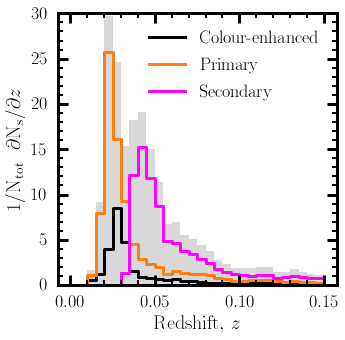

In [6]:
redshifts_pri = pri['NSA_Z']
redshifts_sec = sec['NSA_Z']
redshifts_cen = cen['NSA_Z']

redshifts = np.concatenate([redshifts_pri,redshifts_sec,redshifts_cen])

fig,ax=plt.subplots(figsize=(5,5))
ax.minorticks_on()
ax.tick_params(axis='both',which='major',direction='in',length=10,width=3,labelsize=18,right=1,top=1)
ax.tick_params(axis='both',which='minor',direction='in',length=5,width=2,right=1,top=1)
ax.tick_params(axis='both',which='major',pad=10)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)

def hist(ax,zs,c='black'):
    xedges = np.linspace(0,0.15,31,endpoint=True)
    widths = (xedges[1:]-xedges[:-1])
    xcs = xedges[:-1]+widths/2.
    H,xedges=np.histogram(zs,bins=xedges)
    PDF = H/np.sum(H)/widths
    ax.bar(x=xcs,height=PDF,width=widths,alpha=0.3,color='Gray',zorder=-2)
    return np.sum(H)

def step(ax,zs,bigH,c='black',label='None'):
    xedges = np.linspace(0,0.15,31,endpoint=True)
    widths = (xedges[1:]-xedges[:-1])
    xcs = xedges[:-1]+widths/2.
    H,xedges=np.histogram(zs,bins=xedges)
    PDF = H/bigH/widths
    ax.step(xedges,np.concatenate((PDF,[PDF[-1]])),where='post',color=c,linewidth=3,label=label,zorder=-1)
    return ax
    

bigH = hist(ax,redshifts,c='C0')

step(ax,redshifts_cen,bigH,c='black',label='Colour-enhanced')
step(ax,redshifts_pri,bigH,c='C1',label='Primary')
step(ax,redshifts_sec,bigH,c='magenta',label='Secondary')
ax.set_xlabel(r'Redshift, $z$',fontsize=20)
ax.set_ylabel(r'$1/$N$_{\mathrm{tot}}\;\;\partial $N$_{\mathrm{s}}/ \partial z$',fontsize=20)
ax.legend(frameon=False,loc=0,fontsize=18)
ax.set_ylim(0,30)

fig.savefig('/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/MaNGA_Redshifts.pdf',bbox_inches='tight')

## Create tables from which to draw insertion statistics

These tables should include the objIDs, redshifts, run, rerun, camcol, and field values for all of the MaNGA selection candidates in the table above. The redshifts can be drawn from the catalogue above. The objIDs, run, rerun, camcol, field values can be drawn from the SDSS spectroscopic sample for ease. Ultimately, the MaNGA sample is drawn from this parent sample without priors on field statistics. Therefore, selecting field statistics from this parent sample is justified.

Need half-stellar mass radii in headers for determining which IFU design to assign.

## Redshift table

In [9]:
targetcat_name = 'MaNGA_targets_extNSA_tiled_ancillary.fits'
if not os.access(targetcat_name,0):
    targetcat_url = 'https://data.sdss.org/sas/dr16/manga/target/v1_2_27/{}'.format(targetcat_name)
    os.system('wget {}'.format(targetcat_url))

data = fits.getdata(targetcat_name)
bitmask = data['MANGA_TARGET1']
pri_mask = (bitmask & 1024)!=0
sec_mask = (bitmask & 2048)!=0
cen_mask = (bitmask & 4096)!=0

# full manga sample
manga_all = data[(pri_mask+sec_mask+cen_mask)>=1]

manga_primary = data[pri_mask]
manga_secondary = data[sec_mask]
manga_cen = data[cen_mask]

# print(manga_all['IFUTARGETSIZE'])
# print(manga_all['IFUDESIGNSIZE'])
# print(manga_all['NSA_ELPETRO_TH50_R']*1.5*2)

# all redshifts
catalog_name = 'MaNGA_target_redshifts-all.txt'
np.savetxt(catalog_name,manga_all['NSA_Z'])
cp(catalog_name,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')
# primary sample
catalog_name = 'MaNGA_target_redshifts-primary.txt'
np.savetxt(catalog_name,manga_primary['NSA_Z'])
cp(catalog_name,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')
# secondary sample
catalog_name = 'MaNGA_target_redshifts-secondary.txt'
np.savetxt(catalog_name,manga_secondary['NSA_Z'])
cp(catalog_name,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')
# colour-enhanced sample
catalog_name = 'MaNGA_target_redshifts-cen.txt'
np.savetxt(catalog_name,manga_cen['NSA_Z'])
cp(catalog_name,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')


'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources/MaNGA_target_redshifts-cen.txt'

## Create table to draw SDSS photometry statistics

Take SDSS DR7 spectroscopic sample field info. Redshifts can be drawn independently from the table above.

In [67]:
import pymysql
import numpy as np

cnf_path = '/home/bottrell/.mysql/lauca.cnf'
db = pymysql.connect(host='lauca.phys.uvic.ca',
                     user='cbottrell',
                     database='sdss',
                     read_default_file=cnf_path)
c = db.cursor()
dbcmd = ['SELECT f.objID,f.run,f.rerun,f.camcol,f.field',
         'FROM dr7_uberuber as u JOIN dr7_field_info as f',
         'ON u.objID=f.objID',
         'WHERE u.specclass=2']
c.execute(' '.join(dbcmd))
data = np.asarray(c.fetchall())
c.close()
db.close()
objIDs = data[:,0].astype(int)
runs = data[:,1].astype(int)
reruns = data[:,2].astype(int)
camcols = data[:,3].astype(int)
fields = data[:,4].astype(int)

data = zip(objIDs,runs,reruns,camcols,fields)
data = np.array(list(data),dtype=[('OBJID', 'i8'), ('RUN', 'i4'), ('RERUN', 'i4'), ('CAMCOL','i4'),('FIELD','i4')])
outfile = 'SDSS_DR7_SPEC_FIELD_INFO.npy'
np.save(outfile,data)
cp(outfile,'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources')

'/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources/SDSS_DR7_SPEC_FIELD_INFO.npy'

# Generate a synthetic MaNGA observation

FOV [kpc]: 107.9381304150456
Seeing FWHM [arcsec]: 1.84116
Redshift: 0.08812185376882553
FOV [arcsec]: 63.1406929924782
Primary IFU design: N37
Secondary IFU design: N127


/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:258: RuntimeWarning: invalid value encountered in true_divide
  vbar = sum_wivi/sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:259: RuntimeWarning: invalid value encountered in greater
  Nprime = np.nansum(losvd_data>0,axis=-1)
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: divide by zero encountered in true_divide
  vstd /= (Nprime-1)/Nprime*sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: invalid value encountered in multiply
  vstd /= (Nprime-1)/Nprime*sum_wi
/home/bottrell/virtualenvs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/home/bottrell/virtualenvs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log10


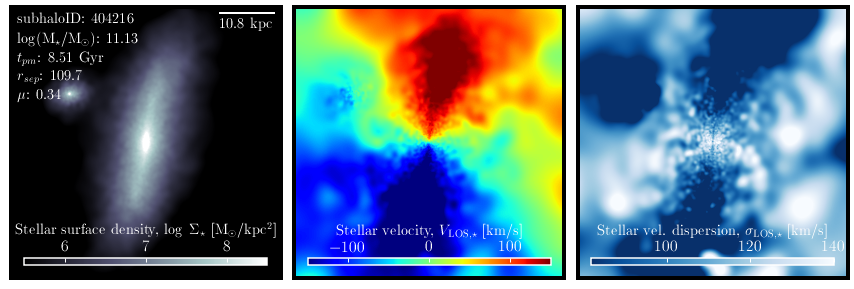

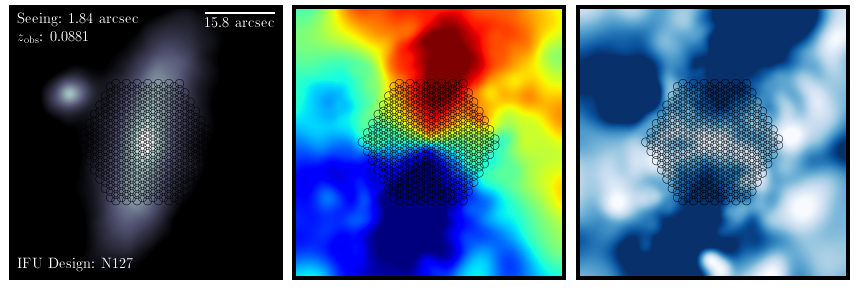

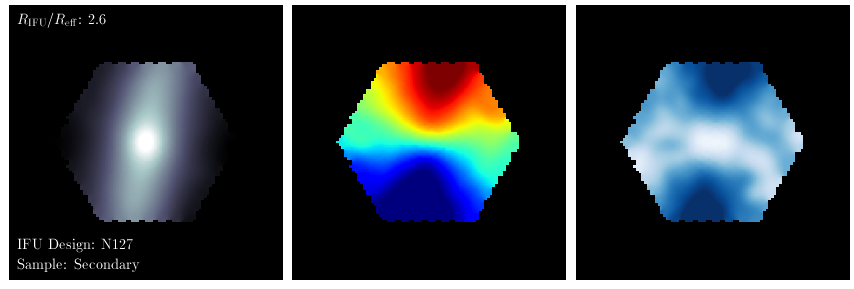

In [29]:
def overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design='N127'):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.
    yc_pixels = yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel
    for ax in axarr:
        for xy in zip(xc_pixels.flat,yc_pixels.flat):
            core = Circle(xy=xy,radius=core_diameter_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None',lw=0.5)
            ax.add_artist(core)
    return fig,axarr

def apply_ifu_design(datacube,arcsec_per_pixel,manga_ifu_design):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                             n_observations='Classic',
                                                             rotation_degrees = 0.,
                                                             return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = (xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.).flatten() # convert to pixels and center
    yc_pixels = (yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.).flatten() # convert to pixels and center
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel # convert to pixels
    
    core_arrays,weights = RealSim_IFS.Fiber_Observe(datacube,xc_pixels,yc_pixels,
                                                    core_diameter_pixels,return_weights=True)

    output_grid_dims = (100,100)
    out_arcsec_per_pixel = 0.5
    xc_pixels = xc_arcsec/out_arcsec_per_pixel + output_grid_dims[1]/2.
    yc_pixels = yc_arcsec/out_arcsec_per_pixel + output_grid_dims[0]/2.
    core_diameter_pixels = core_diameter_arcsec/out_arcsec_per_pixel
    
    outcube,weight_map = RealSim_IFS.Fiber_to_Grid(core_arrays,xc_pixels,yc_pixels,core_diameter_pixels,
                                               grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                               gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                               rlim_pixels=1.6/out_arcsec_per_pixel)
    outcube[outcube==0.]=np.nan
    return outcube,out_arcsec_per_pixel


def main(subhaloID,snapID,ptype,camera):
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
    filename = 'losvd_TNG100-1_{}_{}_{}_{}__32.fits'.format(snapID,subhaloID,ptype,camera)
    if not os.access('{}/{}'.format(wdir,filename),0):
        losvd_dir = '/home/bottrell/projects/def-simardl/bottrell/share/mhani/LOSVD'
        cp('{}/{}'.format(losvd_dir,filename),wdir)   
    datacube = np.transpose(fits.getdata(filename),[2,0,1])
    maps = RealSim_IFS.Generate_Maps_From_File(filename)
    hdr = fits.getheader(filename)
    
    # Ideal diagnostic plot
    
    fig,axarr,vmins,vmaxs = plot(maps,hdr,return_vmaxima=True)
    outdir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/TNG100-1'
    outname = 'Diagnostic_TNG100-1_snapNum-{}_subhaloID-{}_ptype-{}_camera-{}_IDEAL.pdf'.format(snapID,subhaloID,ptype,camera)
    outfile = '{}/{}'.format(outdir,outname)
    fig.savefig(outfile,bbox_inches='tight')
    
    # Cosmology 
    
    cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315)
    # physical spatial pixel scale in datacube
    kpc_per_pixel = hdr['FOV_KPC']/hdr['NPIXEL']
    print("FOV [kpc]:",hdr['FOV_KPC'])
    # The FOVSIZE keyword gives the size of the FOV in
    # units of FOVUNIT (in this case, stellar half-mass radii)
    R_eff_kpc = hdr['FOV_KPC']/hdr['FOVSIZE']
    
    # Draw redshift and atmospheric seeing from real galaxy distributions

    seed = 94182812
    seeing_fwhm_arcsec = RealSim_IFS.get_random_seeing_manga(seed=seed)
    redshift = RealSim_IFS.get_random_redshift_manga(seed=seed)
    print("Seeing FWHM [arcsec]:",seeing_fwhm_arcsec)
    print("Redshift:",redshift)
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    print('FOV [arcsec]:', hdr['FOV_KPC']/kpc_per_arcsec)
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    
    # Create temporary convolution file (computationally intensive step)
    
    convolved_name = 'convolved_tmp.npy'
    if os.access(convolved_name,0):
        datacube = np.load(convolved_name)
    else:   
        start = time.time()
        datacube = RealSim_IFS.apply_seeing(datacube=datacube,kpc_per_pixel=kpc_per_pixel,redshift=redshift,
                                           seeing_fwhm_arcsec=seeing_fwhm_arcsec,seeing_model='manga',
                                           use_threading=False,n_threads=1,cosmo=cosmo)
        print('Convolution time:{}'.format(time.time()-start))
        np.save('convolved_tmp.npy',datacube)
    maps = RealSim_IFS.Generate_Maps_From_Data(filename,datacube)
    fig,axarr = plot(maps,hdr,show_info=False,show_colorbars=False,use_vmaxima=True,vmins=vmins,vmaxs=vmaxs)
    ax = axarr[0]
    ax.axhline(y=0.975*maps.shape[1],xmax=0.975,xmin=0.725,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} arcsec'.format(2.5*R_eff_arcsec),ha='right',va='top',
            color='white',size=15,transform=ax.transAxes)
    txts = [r'Seeing: {:.2f} arcsec \\'.format(seeing_fwhm_arcsec),
            r'$z_{{\mathrm{{obs}}}}$: {:.4f}'.format(redshift)]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07

    # pick ifu for target
    
    manga_ifu_designs = np.array(['N19','N37','N61','N91','N127'])
    manga_ifu_diameters_arcsec = np.array([12.5,17.5,22.5,27.5,32.5]) # [arcsec]
    
    # primary ifu design
    
    primary_sample_arg = np.argmin(np.abs(2*1.5*R_eff_arcsec-manga_ifu_diameters_arcsec))
    primary_design = manga_ifu_designs[primary_sample_arg]
    print('Primary IFU design:',primary_design)
    
    # secondary ifu design
    
    secondary_sample_arg = np.argmin(np.abs(2*2.5*R_eff_arcsec-manga_ifu_diameters_arcsec))
    secondary_design = manga_ifu_designs[secondary_sample_arg]
    print('Secondary IFU design:',secondary_design)
    
    # sample ifu design overlay
    fig,axarr = overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design=secondary_design)
    txts = [r'IFU Design: {}'.format(secondary_design),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.025+offset,''.join(txt),transform=ax.transAxes,ha='left',va='bottom',color='white',size=15)
        offset+=0.07
        
    outname = 'Diagnostic_TNG100-1_snapNum-{}_subhaloID-{}_ptype-{}_camera-{}_CONV.pdf'.format(snapID,subhaloID,ptype,camera)
    outfile = '{}/{}'.format(outdir,outname)
    fig.savefig(outfile,bbox_inches='tight')
    
    # generate ifu observation with design
    
    outcube_name = 'outcube_tmp.npy'
    if os.access(outcube_name,0):
        outcube = np.load(outcube_name)
        out_arcsec_per_pixel = 0.5
    else:   
        start = time.time()
        outcube,out_arcsec_per_pixel = apply_ifu_design(datacube,arcsec_per_pixel,secondary_design)
        print('Compute time for IFU "observation" [s]:',time.time()-start)
        np.save(outcube_name,outcube)
    maps = RealSim_IFS.Generate_Maps_From_Data(filename,outcube)
    out_kpc_per_pixel = kpc_per_arcsec/out_arcsec_per_pixel
    factor = (arcsec_per_pixel/out_arcsec_per_pixel)**2
    fig,axarr = plot(maps,hdr,show_info=False,show_colorbars=False,
                     use_vmaxima=True,vmins=vmins,vmaxs=vmaxs,factor=factor)
    ax = axarr[0]
    txts = [r'$R_{{\mathrm{{IFU}}}}/R_{{\mathrm{{eff}}}}$: {:.1f}'.format(manga_ifu_diameters_arcsec[secondary_sample_arg]/2/R_eff_arcsec),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
    txts = [r'Sample: Secondary',
            r'IFU Design: {}'.format(secondary_design),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.025+offset,''.join(txt),transform=ax.transAxes,ha='left',va='bottom',color='white',size=15)
        offset+=0.07
    
    outname = 'Diagnostic_TNG100-1_snapNum-{}_subhaloID-{}_ptype-{}_camera-{}_REALSIM.pdf'.format(snapID,subhaloID,ptype,camera)
    outfile = '{}/{}'.format(outdir,outname)
    fig.savefig(outfile,bbox_inches='tight')

    
if __name__ == '__main__':
    
    gc.collect()

    snapID = 99
    subhaloID = 404216
    camera = 'i0'
    ptype = 'stars'
    
    main(subhaloID,snapID,ptype,camera)

## Making primary, secondary, and colour-enchanced sample observations

Here I will draw from the redshift distributions of each individual sample rather than the survey as a whole. The appropriate IFU design will be selected for each sample (2.5 $R_e$ for the secondary and 1.5 $R_e$ for the primary and colour-enchanced samples). This version will store the output as `FITS` files.

In [8]:
def overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design='N127'):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.
    yc_pixels = yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel
    for ax in axarr:
        for xy in zip(xc_pixels.flat,yc_pixels.flat):
            core = Circle(xy=xy,radius=core_diameter_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None',lw=0.5)
            ax.add_artist(core)
    return fig,axarr

def apply_ifu_design(datacube,arcsec_per_pixel,manga_ifu_design):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                             n_observations='Classic',
                                                             rotation_degrees = 0.,
                                                             return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = (xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.).flatten() # convert to pixels and center
    yc_pixels = (yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.).flatten() # convert to pixels and center
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel # convert to pixels
    
    core_arrays,weights = RealSim_IFS.Fiber_Observe(datacube,xc_pixels,yc_pixels,
                                                    core_diameter_pixels,return_weights=True)

    output_grid_dims = (100,100)
    out_arcsec_per_pixel = 0.5
    xc_pixels = xc_arcsec/out_arcsec_per_pixel + output_grid_dims[1]/2.
    yc_pixels = yc_arcsec/out_arcsec_per_pixel + output_grid_dims[0]/2.
    core_diameter_pixels = core_diameter_arcsec/out_arcsec_per_pixel
    
    outcube,weight_map = RealSim_IFS.Fiber_to_Grid(core_arrays,xc_pixels,yc_pixels,core_diameter_pixels,
                                               grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                               gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                               rlim_pixels=1.6/out_arcsec_per_pixel)
    outcube[outcube==0.]=np.nan
    return outcube,out_arcsec_per_pixel


def main(subhaloID,snapID,ptype,camera,sample,seed=0):
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
        
    filename = 'losvd_TNG100-1_{}_{}_{}_{}__32.fits'.format(snapID,subhaloID,ptype,camera)
    if not os.access('{}/{}'.format(wdir,filename),0):
        losvd_dir = '/home/bottrell/projects/def-simardl/bottrell/share/mhani/LOSVD'
        cp('{}/{}'.format(losvd_dir,filename),wdir)
        
    datacube = np.transpose(fits.getdata(filename),[2,0,1])
    hdr = fits.getheader(filename)
    
    # Cosmology 
    
    cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315)
    # physical spatial pixel scale in datacube
    kpc_per_pixel = hdr['FOV_KPC']/hdr['NPIXEL']
    print("FOV [kpc]:",hdr['FOV_KPC'])
    # The FOVSIZE keyword gives the size of the FOV in
    # units of FOVUNIT (in this case, stellar half-mass radii)
    R_eff_kpc = hdr['FOV_KPC']/hdr['FOVSIZE']
    
    # Redshifts from real galaxy distribution
    
    zcat_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources'
    
    if sample == 'PRI':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'primary')
    elif sample == 'SEC':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'secondary')
    elif sample == 'CEN':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'cen')
    else:
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'all')
    redshift_pool = np.loadtxt(zcat_name)
    
    # IFU design sizes from which to choose
    
    N_Reff = (2.5 if sample=='SEC' else 1.5)
    manga_ifu_designs = np.array(['N19','N37','N61','N91','N127'])
    manga_ifu_diameters_arcsec = np.array([12.5,17.5,22.5,27.5,32.5]) # [arcsec]
    
    redshift = RealSim_IFS.get_random_redshift_manga(redshift_pool=redshift_pool,seed=seed)
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    ifu_design_arg = np.argmin(np.abs(2*N_Reff*R_eff_arcsec-manga_ifu_diameters_arcsec))
    ifu_design = manga_ifu_designs[ifu_design_arg]
    ifu_diameter_arcsec = manga_ifu_diameters_arcsec[ifu_design_arg]
    
    # If the design does not cover out to at least 0.75*N_Reff, choose another redshift and return new seed
    
    seeds = range(int(1e12))
    while ((ifu_diameter_arcsec/2)/(R_eff_arcsec*N_Reff))<0.75:
        seed = random.choice(seeds)
        redshift = RealSim_IFS.get_random_redshift_manga(redshift_pool=redshift_pool,seed=seed)
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
        R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
        ifu_design_arg = np.argmin(np.abs(2*N_Reff*R_eff_arcsec-manga_ifu_diameters_arcsec))
        ifu_design = manga_ifu_designs[ifu_design_arg]
        ifu_diameter_arcsec = manga_ifu_diameters_arcsec[ifu_design_arg]
    print("Redshift:",redshift)
    
    # Draw atmospheric seeing from real galaxy distribution
    
    seeing_fwhm_arcsec = RealSim_IFS.get_random_seeing_manga(seed=seed)
    print("Seeing FWHM [arcsec]:",seeing_fwhm_arcsec)
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    print('FOV [arcsec]:', hdr['FOV_KPC']/kpc_per_arcsec)
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    print('R_eff [arcsec]:', R_eff_arcsec)
    print('IFU design:',ifu_design)
    
    # Create temporary convolution file (computationally intensive step)

    convolved_name = 'convolved_tmp.npy'
    if os.access(convolved_name,0):
        # os.remove(convolved_name)
        datacube = np.load(convolved_name)
    else:   
        start = time.time()
        datacube = RealSim_IFS.apply_seeing(datacube=datacube,kpc_per_pixel=kpc_per_pixel,redshift=redshift,
                                           seeing_fwhm_arcsec=seeing_fwhm_arcsec,seeing_model='manga',
                                           use_threading=False,n_threads=1,cosmo=cosmo)
        print('Convolution time:{}'.format(time.time()-start))
        np.save('convolved_tmp.npy',datacube) 
    
    # generate ifu observation with design
    outcube_name = 'losvd_TNG100-1_{}_{}_{}_{}__32_MANGA_{}.fits'.format(snapID,subhaloID,ptype,camera,sample)
    if os.access(outcube_name,0):
        os.remove(outcube_name) 
#     start = time.time()
#     outcube,out_arcsec_per_pixel = apply_ifu_design(datacube,arcsec_per_pixel,ifu_design)
#     print('Compute time for IFU "observation" [s]:',time.time()-start)
#     np.save('outcube_tmp.npy',outcube)

    outcube = np.load('outcube_tmp.npy')
    out_arcsec_per_pixel=0.5
    
    hdu_pri = fits.PrimaryHDU(outcube)
    
    warnings.simplefilter('ignore', category=AstropyWarning)
    hdr['FOVSIZE'] = (outcube.shape[1]*out_arcsec_per_pixel,'FOV size')
    hdr['FOVUNIT'] = ('arcsec','FOV size units')
    hdr['FOV_KPC'] = (outcube.shape[1]*out_arcsec_per_pixel*kpc_per_arcsec,'[kpc]')
    hdr['NPIXEL'] = (outcube.shape[1],'spatial grid resolution')
    hdr.append(('SAMPLE',sample,'MaNGA sample'),end=True)
    hdr.append(('SEED',seed,'RealSim-IFS random seed'),end=True)
    hdr.append(('REDSHIFT',redshift,'Redshift'),end=True)
    hdr.append(('SEEING',seeing_fwhm_arcsec,'Seeing FWHM [arcsec]'),end=True)
    hdr.append(('SEEMDL','MaNGA','Seeing Model'),end=True)
    hdr.append(('FOV_ARC',outcube.shape[1]*out_arcsec_per_pixel,'Field of view [arcsec]'),end=True)
    hdr.append(('DESIGN',ifu_design,'MaNGA IFU design'),end=True)
    hdr.append(('IFUDIAM',ifu_diameter_arcsec,'IFU diameter [arcsec]'),end=True)
    hdr.append(('F_REFF',(ifu_diameter_arcsec/2)/(R_eff_arcsec*N_Reff),'R_IFU / Reff / N_Reff'),end=True)
    hdr.append(('N_OBS','Classic','MaNGA dither pattern'),end=True)
    hdr.append(('ROTATE',0.,'IFU rotation [degrees]'),end=True)
    hdr.append(('COSMO','FLAT_LCDM','Cosmology'),end=True)
    hdr.append(('OMEGA_M',cosmo.Om(0),'Matter density'),end=True)
    hdr.append(('OMEGA_L',cosmo.Ode(0),'Dark energy density'),end=True)
    hdr.append(('SCALE_1',out_arcsec_per_pixel,'[arcsec/pixel]'),end=True)
    hdr.append(('SCALE_2',kpc_per_arcsec*out_arcsec_per_pixel,'[kpc/pixel]'),end=True)
    hdr.append(('SCALE_3',kpc_per_arcsec,'[kpc/arcsec]'),end=True)
    hdr.append(('LUMDIST',cosmo.luminosity_distance(z=redshift).value,'Luminosity Distance [Mpc]'),end=True)

    hdu_pri.header = hdr
    hdu_pri.writeto(outcube_name)
    
    output_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/LOSVD'
    cp(outcube_name,output_dir)

    
if __name__ == '__main__':
    
    gc.collect()

    snapID = 99
    subhaloID = 404216
    camera = 'i0'
    ptype = 'stars'
    
    # primary, secondary, and colour-enhanced
    samples = ['PRI','SEC','CEN']
    
    seed = 87284729
    #seed = 1031432
    
    main(subhaloID,snapID,ptype,camera,sample='PRI',seed=seed)

FOV [kpc]: 107.9381304150456
Redshift: 0.03686974197626114
Seeing FWHM [arcsec]: 1.50345
FOV [arcsec]: 142.00994639116806
R_eff [arcsec]: 14.200994639116804
IFU design: N127


In [17]:
filename = 'losvd_TNG100-1_99_404216_stars_i0__32_MANGA_PRI.fits'

datacube = fits.getdata(filename)

header = fits.getheader(filename)
header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
NAXIS3  =                  300                                                  
EXTEND  =                    T                                                  
PARTTYPE= 'stars   '           / particle type in maps                          
AXIS    = 'i0      '           / instrument                                     
FOVSIZE =                 50.0 / FOV size                                       
FOVUNIT = 'arcsec  '           / FOV size units                                 
FOV_KPC =    38.00372197794117 / [kpc]                                          
NPIXEL  =                  1

/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:258: RuntimeWarning: invalid value encountered in true_divide
  vbar = sum_wivi/sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:259: RuntimeWarning: invalid value encountered in greater
  Nprime = np.nansum(losvd_data>0,axis=-1)
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: divide by zero encountered in true_divide
  vstd /= (Nprime-1)/Nprime*sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: invalid value encountered in multiply
  vstd /= (Nprime-1)/Nprime*sum_wi
/home/bottrell/virtualenvs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10


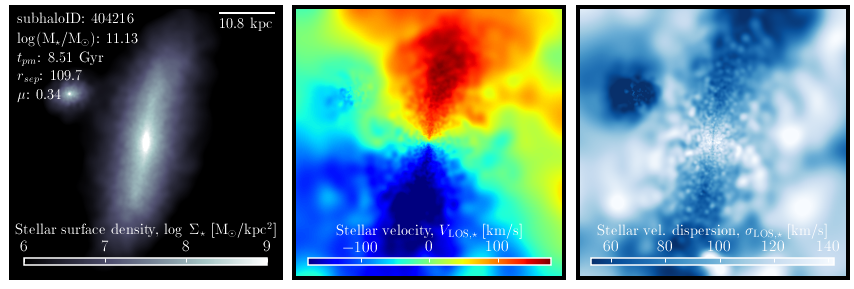

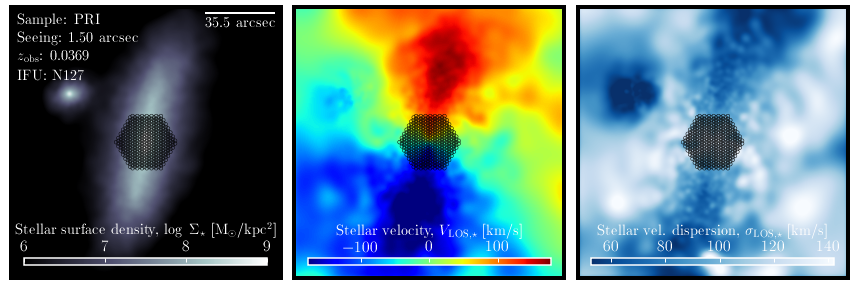

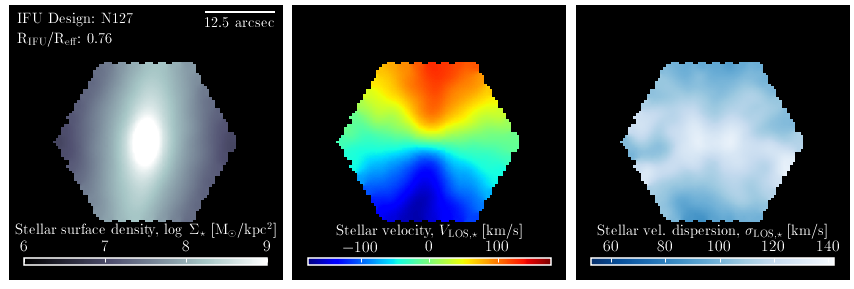

In [16]:
def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=16)
    cbar.set_label(label, color=colour, size=15)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def plot(maps,header,vmins=None,vmaxs=None,return_vmaxima=False,show_cmap=True):
    
    fov_kpc = header['FOV_KPC']
    npixels = header['NPIXEL']
    subhaloID = header['SUBID']
    camera = header['AXIS']
    ptype = header['PARTTYPE']
    snapID = header['SNAPNUM']
    kpc_per_pixel = fov_kpc/npixels

    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)
    
    # Stellar Surface Density
    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m0min = vmins[0]
        m0max = vmaxs[0]
    else:
        m0min = np.around((4.5-2*np.log10(kpc_per_pixel))*2)/2
        m0max = np.around(np.nanpercentile(np.log10(maps[0]/kpc_per_pixel**2),99.9)*2)/2
    im = ax.imshow(np.log10(maps[0]/kpc_per_pixel**2),vmin=m0min,vmax=m0max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}$/kpc$^2$]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)
  
    # Velocity
    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m1min = vmins[1]
        m1max = vmaxs[1]
    else:
        m1min = np.abs(np.nanpercentile(maps[1],1))
        m1max = np.abs(np.nanpercentile(maps[1],99))
        m1max = (m1min+m1max)/2
        m1min = -m1max
    im = ax.imshow(maps[1],vmin=m1min,vmax=m1max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)

    # Velocity dispersion
    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m2min = vmins[2]
        m2max = vmaxs[2]
    else:
        m2min = np.abs(np.nanpercentile(maps[2],1))
        m2max = np.abs(np.nanpercentile(maps[2],99))
    im = ax.imshow(maps[2],vmin=m2min,vmax=m2max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)
    
    vmins = [m0min,m1min,m2min]
    vmaxs = [m0max,m1max,m2max]
    
    if return_vmaxima:
        return fig,axarr,vmins,vmaxs
    else:
        return fig,axarr
    
def add_ideal_info(ax,header):
    
    fov_kpc = header['FOV_KPC']
    npixels = header['NPIXEL']
    subhaloID = header['SUBID']
    camera = header['AXIS']
    ptype = header['PARTTYPE']
    snapID = header['SNAPNUM']
    kpc_per_pixel = fov_kpc/npixels
    
    # get ancillary data from database
    cnf_path='/home/bottrell/.mysql/lauca.cnf'
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell',
                         database='IllustrisTNG100_1',
                         read_default_file=cnf_path)
    c = db.cursor()
    dbcmd = ['SELECT Mstar,Tpostmerger,rsep,MassRatio',
             'FROM Environment',
             'WHERE DB_ID="{}_{}"'.format(snapID,subhaloID)]
    c.execute(' '.join(dbcmd))
    data = np.array(c.fetchall())[0]
    c.close()
    db.close()
    mstar=data[0]
    tpost=data[1]
    rsep=data[2]
    mu=data[3]
    if rsep>300: rsep=999
        
    txts = [r'subhaloID: {} \\'.format(subhaloID),
            r'$\log($M$_{{\star}}/$M$_{{\odot}}$): {:0.2f} \\'.format(mstar),
            r'$t_{{pm}}$: {:0.2f} Gyr \\'.format(tpost),
            r'$r_{{sep}}$: {:.1f} \\'.format(rsep),
            r'$\mu$: {:.2f}'.format(mu)]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
    ax.axhline(y=0.975*npixels,xmax=0.975,xmin=0.775,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} kpc'.format(fov_kpc/10),ha='right',va='top',color='white',size=15,transform=ax.transAxes)
    
def overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design='N127'):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.
    yc_pixels = yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel
    for ax in axarr:
        for xy in zip(xc_pixels.flat,yc_pixels.flat):
            core = Circle(xy=xy,radius=core_diameter_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None',lw=0.5)
            ax.add_artist(core)
    return fig,axarr

def add_conv_info(ax,header_ideal,header_real):
    
    ax.axhline(y=0.975*header_ideal['NPIXEL'],xmax=0.975,xmin=0.725,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} arcsec'.format(2.5*header_ideal['FOV_KPC']/10/header_real['SCALE_3']),ha='right',va='top',
            color='white',size=15,transform=ax.transAxes)
    txts = [r'Sample: {}'.format(header_real['SAMPLE']),
            r'Seeing: {:.2f} arcsec \\'.format(header_real['SEEING']),
            r'$z_{{\mathrm{{obs}}}}$: {:.4f} \\'.format(header_real['REDSHIFT']),
            r'IFU: {}'.format(header_real['DESIGN']),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
        
def add_real_info(ax,header_real):
    
    txts = [r'IFU Design: {}'.format(header_real['DESIGN']),
            r'R$_{{\mathrm{{IFU}}}}/$R$_{{\mathrm{{eff}}}}$: {:.2f}'.format(header_real['F_REFF']),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
    ax.axhline(y=0.975*header_real['NPIXEL'],xmax=0.975,xmin=0.725,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} arcsec'.format(2.5*header_real['FOVSIZE']/10),ha='right',va='top',
            color='white',size=15,transform=ax.transAxes)

def main(subhaloID,snapID,ptype,camera,sample):
    
    figure_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/TNG100-1'
    
    _figname_ = '{}/losvd_TNG100-1_{}_{}_{}_{}__32_MANGA_{}.pdf' # .format(snapID,subhaloID,ptype,camera,sample)
    
    filename_ideal = 'losvd_TNG100-1_{}_{}_{}_{}__32.fits'.format(snapID,subhaloID,ptype,camera)
    data_ideal = fits.getdata(filename_ideal)
    header_ideal = fits.getheader(filename_ideal)
    maps_ideal = RealSim_IFS.Generate_Maps_From_File(filename_ideal)
    
    filename_real = 'losvd_TNG100-1_{}_{}_{}_{}__32_MANGA_{}.fits'.format(snapID,subhaloID,ptype,camera,sample)
    data_real = fits.getdata(filename_real)
    header_real = fits.getheader(filename_real)
    maps_real = RealSim_IFS.Generate_Maps_From_Data(filename_real,data_real)
    
    fig1,axarr1,vmins,vmaxs = plot(maps_ideal,header_ideal,return_vmaxima=True)
    add_ideal_info(axarr1[0],header_ideal)
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'IDEAL')
    fig1.savefig(figname,bbox_inches='tight')
    
    maps_conv = RealSim_IFS.apply_seeing(maps_ideal, header_ideal['FOV_KPC']/header_ideal['NPIXEL'],
                                         redshift = header_real['REDSHIFT'], seeing_model='manga', 
                                         seeing_fwhm_arcsec=header_real['SEEING'], 
                                         cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315), 
                                         use_threading=False, n_threads=1)
    
    fig2,axarr2 = plot(maps_conv,header_ideal,vmaxs=vmaxs,vmins=vmins)
    add_conv_info(axarr2[0],header_ideal,header_real)
    arcsec_per_pixel = header_ideal['FOV_KPC']/header_ideal['NPIXEL']/header_real['SCALE_3']
    overlay_ifu_design(fig2,axarr2,maps_conv,arcsec_per_pixel,manga_ifu_design=header_real['DESIGN'])
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'CONV-{}'.format(header_real['SAMPLE']))
    fig2.savefig(figname,bbox_inches='tight')
    
    fig3,axarr3 = plot(maps_real,header_real,vmins=vmins,vmaxs=vmaxs)
    add_real_info(axarr3[0],header_real)
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'REAL-{}'.format(header_real['SAMPLE']))
    fig3.savefig(figname,bbox_inches='tight')
        
if __name__ == '__main__':
    
    subhaloID = 404216
    snapID = 99
    ptype = 'stars'
    camera = 'i0'
    sample = 'PRI'

    main(subhaloID,snapID,ptype,camera,sample='PRI')

# Combine

The next block combines all of the code built in the previous cells into a single block which produces:

1) The output datacubes for primary, secondary, and colour-enchanced samples

2) The associated moment map figures

FOV [kpc]: 67.69446802941755
Redshift: 0.05443118140101433
Seeing FWHM [arcsec]: 1.34227
FOV [arcsec]: 61.611865868791426
R_eff [arcsec]: 6.161186586879143
IFU design: N127
Starting convolution...

Convolution time [s]: 618.2018327713013

Starting observation...

Compute time for IFU "observation" [s]: 268.91054129600525



/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:258: RuntimeWarning: invalid value encountered in true_divide
  vbar = sum_wivi/sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:259: RuntimeWarning: invalid value encountered in greater
  Nprime = np.nansum(losvd_data>0,axis=-1)
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: divide by zero encountered in true_divide
  vstd /= (Nprime-1)/Nprime*sum_wi
/scratch/bottrell/Merger_Kinematics/RealSim-IFS/RealSim_IFS.py:261: RuntimeWarning: invalid value encountered in multiply
  vstd /= (Nprime-1)/Nprime*sum_wi
/home/bottrell/virtualenvs/p37/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in log10


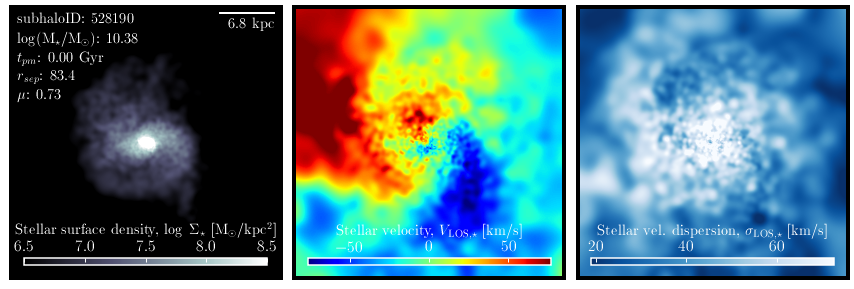

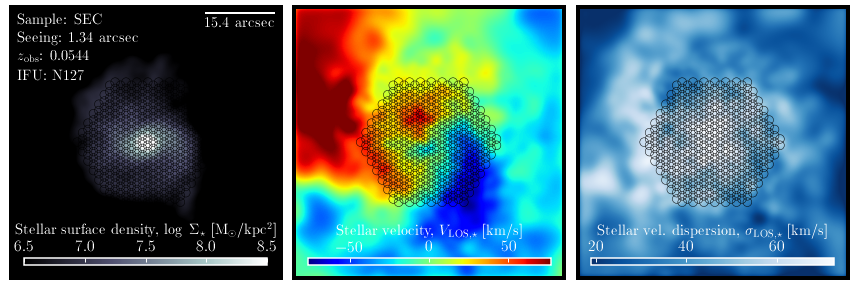

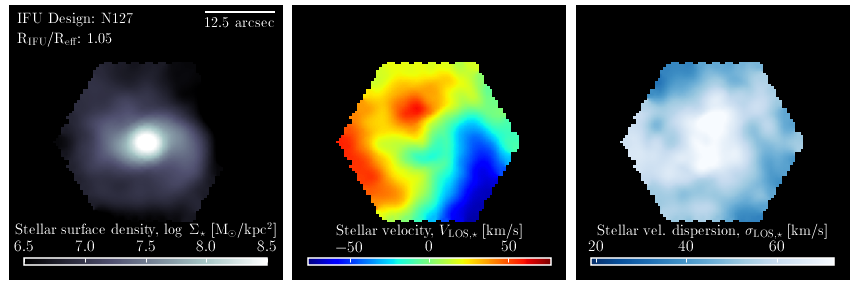

In [3]:
import os,sys,time,random
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Circle
import numpy as np
from astropy.io import fits
from astropy.utils.exceptions import AstropyWarning
from shutil import copy as cp
from copy import copy
from glob import glob
import RealSim_IFS
import warnings
from time import process_time 
import multiprocessing as mp
from astropy.cosmology import FlatLambdaCDM
from astropy.convolution import convolve
import pymysql 
import gc

rc('font',**{'family':'serif'})
rc('text', usetex=True)

def add_colorbar(im,ax,label,colour='white'):
    axin = ax.inset_axes(
            [0.05,0.05, 0.9, 0.025], transform=ax.transAxes)
    cbar = plt.colorbar(im, cax=axin, orientation='horizontal')
    cbar.ax.tick_params(color=colour, labelcolor=colour,direction='in',labeltop=1,
                        labelbottom=0,top=1,bottom=0, width=1, labelsize=16)
    cbar.set_label(label, color=colour, size=15)
    cbar.ax.xaxis.set_label_position('top') 
    cbar.outline.set_edgecolor(colour)
    cbar.outline.set_linewidth(1.5)

def plot(maps,header,vmins=None,vmaxs=None,return_vmaxima=False,show_cmap=True):
    
    fov_kpc = header['FOV_KPC']
    npixels = header['NPIXEL']
    subhaloID = header['SUBID']
    camera = header['AXIS']
    ptype = header['PARTTYPE']
    snapID = header['SNAPNUM']
    kpc_per_pixel = fov_kpc/npixels

    fig,axarr = plt.subplots(1,3,figsize=(15,5))
    fig.subplots_adjust(wspace=0.05,hspace=0.05)
    axarr = axarr.flat

    for ax in axarr:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        for spine in ['top','left','right','bottom']:
            ax.spines[spine].set_linewidth(4)
    
    # Stellar Surface Density
    ax = axarr[0]
    cmap = copy(plt.cm.bone)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m0min = vmins[0]
        m0max = vmaxs[0]
    else:
        m0min = np.around((4.5-2*np.log10(kpc_per_pixel))*2)/2
        m0max = np.around(np.nanpercentile(np.log10(maps[0]/kpc_per_pixel**2),99.9)*2)/2
    im = ax.imshow(np.log10(maps[0]/kpc_per_pixel**2),vmin=m0min,vmax=m0max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar surface density, $\log\;\Sigma_{\star}$ [M$_{\odot}$/kpc$^2$]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)
  
    # Velocity
    ax = axarr[1]
    cmap = copy(plt.cm.jet)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m1min = vmins[1]
        m1max = vmaxs[1]
    else:
        m1min = np.abs(np.nanpercentile(maps[1],1))
        m1max = np.abs(np.nanpercentile(maps[1],99))
        m1max = (m1min+m1max)/2
        m1min = -m1max
    im = ax.imshow(maps[1],vmin=m1min,vmax=m1max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar velocity, $V_{\mathrm{LOS,\star}}$ [km/s]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)

    # Velocity dispersion
    ax = axarr[2]
    cmap = copy(plt.cm.Blues_r)
    cmap.set_bad('black', 1.0)
    if vmaxs is not None:
        m2min = vmins[2]
        m2max = vmaxs[2]
    else:
        m2min = np.abs(np.nanpercentile(maps[2],1))
        m2max = np.abs(np.nanpercentile(maps[2],99))
    im = ax.imshow(maps[2],vmin=m2min,vmax=m2max,cmap=cmap,origin='lower',aspect='auto',interpolation=None)
    cbar_colour = 'white'
    label = r'Stellar vel. dispersion, $\sigma_{\mathrm{LOS,\star}}$ [km/s]'
    if show_cmap:
        add_colorbar(im,ax,label,colour=cbar_colour)
    
    vmins = [m0min,m1min,m2min]
    vmaxs = [m0max,m1max,m2max]
    
    if return_vmaxima:
        return fig,axarr,vmins,vmaxs
    else:
        return fig,axarr
    
def add_ideal_info(ax,header):
    
    fov_kpc = header['FOV_KPC']
    npixels = header['NPIXEL']
    subhaloID = header['SUBID']
    camera = header['AXIS']
    ptype = header['PARTTYPE']
    snapID = header['SNAPNUM']
    kpc_per_pixel = fov_kpc/npixels
    
    # get ancillary data from database
    cnf_path='/home/bottrell/.mysql/lauca.cnf'
    db = pymysql.connect(host='lauca.phys.uvic.ca',
                         user='cbottrell',
                         database='IllustrisTNG100_1',
                         read_default_file=cnf_path)
    c = db.cursor()
    dbcmd = ['SELECT Mstar,Tpostmerger,rsep,MassRatio',
             'FROM Environment',
             'WHERE DB_ID="{}_{}"'.format(snapID,subhaloID)]
    c.execute(' '.join(dbcmd))
    data = np.array(c.fetchall())[0]
    c.close()
    db.close()
    mstar=data[0]
    tpost=data[1]
    rsep=data[2]
    mu=data[3]
    if rsep>300: rsep=999
        
    txts = [r'subhaloID: {} \\'.format(subhaloID),
            r'$\log($M$_{{\star}}/$M$_{{\odot}}$): {:0.2f} \\'.format(mstar),
            r'$t_{{pm}}$: {:0.2f} Gyr \\'.format(tpost),
            r'$r_{{sep}}$: {:.1f} \\'.format(rsep),
            r'$\mu$: {:.2f}'.format(mu)]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
    ax.axhline(y=0.975*npixels,xmax=0.975,xmin=0.775,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} kpc'.format(fov_kpc/10),ha='right',va='top',color='white',size=15,transform=ax.transAxes)

def overlay_ifu_design(fig,axarr,datacube,arcsec_per_pixel,manga_ifu_design='N127'):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                   n_observations='Classic',
                                                   rotation_degrees = 0.,
                                                   return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.
    yc_pixels = yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel
    for ax in axarr:
        for xy in zip(xc_pixels.flat,yc_pixels.flat):
            core = Circle(xy=xy,radius=core_diameter_pixels/2,transform=ax.transData,edgecolor='Black',facecolor='None',lw=0.5)
            ax.add_artist(core)
    return fig,axarr

def apply_ifu_design(datacube,arcsec_per_pixel,manga_ifu_design):
    (xc_arcsec,yc_arcsec),params = RealSim_IFS.MaNGA_Observe(bundle_name=manga_ifu_design,
                                                             n_observations='Classic',
                                                             rotation_degrees = 0.,
                                                             return_params=True)
    core_diameter_arcsec = params['core_diameter_arcsec']
    xc_pixels = (xc_arcsec/arcsec_per_pixel+datacube.shape[2]/2.).flatten() # convert to pixels and center
    yc_pixels = (yc_arcsec/arcsec_per_pixel+datacube.shape[1]/2.).flatten() # convert to pixels and center
    core_diameter_pixels = core_diameter_arcsec/arcsec_per_pixel # convert to pixels
    
    core_arrays,weights = RealSim_IFS.Fiber_Observe(datacube,xc_pixels,yc_pixels,
                                                    core_diameter_pixels,return_weights=True)

    output_grid_dims = (100,100)
    out_arcsec_per_pixel = 0.5
    xc_pixels = xc_arcsec/out_arcsec_per_pixel + output_grid_dims[1]/2.
    yc_pixels = yc_arcsec/out_arcsec_per_pixel + output_grid_dims[0]/2.
    core_diameter_pixels = core_diameter_arcsec/out_arcsec_per_pixel
    
    outcube,weight_map = RealSim_IFS.Fiber_to_Grid(core_arrays,xc_pixels,yc_pixels,core_diameter_pixels,
                                               grid_dimensions_pixels=output_grid_dims,use_gaussian_weights=True,
                                               gaussian_sigma_pixels=0.7/out_arcsec_per_pixel,
                                               rlim_pixels=1.6/out_arcsec_per_pixel)
    outcube[outcube==0.]=np.nan
    return outcube,out_arcsec_per_pixel

def add_conv_info(ax,header_ideal,header_real):
    ax.axhline(y=0.975*header_ideal['NPIXEL'],xmax=0.975,xmin=0.725,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} arcsec'.format(2.5*header_ideal['FOV_KPC']/10/header_real['SCALE_3']),ha='right',va='top',
            color='white',size=15,transform=ax.transAxes)
    txts = [r'Sample: {}'.format(header_real['SAMPLE']),
            r'Seeing: {:.2f} arcsec \\'.format(header_real['SEEING']),
            r'$z_{{\mathrm{{obs}}}}$: {:.4f} \\'.format(header_real['REDSHIFT']),
            r'IFU: {}'.format(header_real['DESIGN']),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
        
def add_real_info(ax,header_real):
    txts = [r'IFU Design: {}'.format(header_real['DESIGN']),
            r'R$_{{\mathrm{{IFU}}}}/$R$_{{\mathrm{{eff}}}}$: {:.2f}'.format(header_real['F_REFF']),]
    offset = 0.0
    for txt in txts:
        ax.text(0.025,0.975-offset,''.join(txt),transform=ax.transAxes,ha='left',va='top',color='white',size=15)
        offset+=0.07
    ax.axhline(y=0.975*header_real['NPIXEL'],xmax=0.975,xmin=0.725,c='white',lw=2)
    ax.text(0.975,0.96,'{:.1f} arcsec'.format(2.5*header_real['FOVSIZE']/10),ha='right',va='top',
            color='white',size=15,transform=ax.transAxes)

def main(subhaloID,snapID,ptype,camera,sample,seed=0):
    
    if 'SLURM_TMPDIR' in [key for key in os.environ.keys()]:
        wdir = os.environ['SLURM_TMPDIR']
        os.chdir(wdir)
    
    output_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/LOSVD/TNG100-1'
    outcube_name = 'losvd_TNG100-1_{}_{}_{}_{}__32_MANGA_{}.fits'.format(snapID,subhaloID,ptype,camera,sample)
    if os.access('{}/{}'.format(output_dir,outcube_name),0):
        print('{}\nalready exists in output directory.'.format(outcube_name))
        return None
    
    incube_name = 'losvd_TNG100-1_{}_{}_{}_{}__32.fits'.format(snapID,subhaloID,ptype,camera)
    if not os.access('{}/{}'.format(wdir,incube_name),0):
        losvd_dir = '/home/bottrell/projects/def-simardl/bottrell/share/mhani/LOSVD'
        cp('{}/{}'.format(losvd_dir,incube_name),wdir)
        
    datacube = np.transpose(fits.getdata(incube_name),[2,0,1])
    hdr = fits.getheader(incube_name)
    
    # Cosmology 
    
    cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315)
    # physical spatial pixel scale in datacube
    kpc_per_pixel = hdr['FOV_KPC']/hdr['NPIXEL']
    print("FOV [kpc]:",hdr['FOV_KPC'])
    # The FOVSIZE keyword gives the size of the FOV in
    # units of FOVUNIT (in this case, stellar half-mass radii)
    R_eff_kpc = hdr['FOV_KPC']/hdr['FOVSIZE']
    
    # Redshifts from real galaxy distribution
    
    zcat_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Resources'
    
    if sample == 'PRI':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'primary')
    elif sample == 'SEC':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'secondary')
    elif sample == 'CEN':
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'cen')
    else:
        zcat_name = '{}/MaNGA_target_redshifts-{}.txt'.format(zcat_dir,'all')
    redshift_pool = np.loadtxt(zcat_name)
    
    # IFU design sizes from which to choose
    
    N_Reff = (2.5 if sample=='SEC' else 1.5)
    manga_ifu_designs = np.array(['N19','N37','N61','N91','N127'])
    manga_ifu_diameters_arcsec = np.array([12.5,17.5,22.5,27.5,32.5]) # [arcsec]
    
    redshift = RealSim_IFS.get_random_redshift_manga(redshift_pool=redshift_pool,seed=seed)
    kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    ifu_design_arg = np.argmin(np.abs(2*N_Reff*R_eff_arcsec-manga_ifu_diameters_arcsec))
    ifu_design = manga_ifu_designs[ifu_design_arg]
    ifu_diameter_arcsec = manga_ifu_diameters_arcsec[ifu_design_arg]
    
    # If the design does not cover out to at least 0.75*N_Reff, choose another redshift and return new seed
    
    # Also check that the IFU size is not large than the full field of view
    
    seeds = range(int(1e9))
    while (((ifu_diameter_arcsec/2)/(R_eff_arcsec*N_Reff))<0.75) or (ifu_diameter_arcsec>=R_eff_arcsec*10):
        seed = random.choice(seeds)
        redshift = RealSim_IFS.get_random_redshift_manga(redshift_pool=redshift_pool,seed=seed)
        kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=redshift).value/60. # [kpc/arcsec]
        R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
        ifu_design_arg = np.argmin(np.abs(2*N_Reff*R_eff_arcsec-manga_ifu_diameters_arcsec))
        ifu_design = manga_ifu_designs[ifu_design_arg]
        ifu_diameter_arcsec = manga_ifu_diameters_arcsec[ifu_design_arg]
    print("Redshift:",redshift)
    
    # Draw atmospheric seeing from real galaxy distribution
    
    seeing_fwhm_arcsec = RealSim_IFS.get_random_seeing_manga(seed=seed)
    print("Seeing FWHM [arcsec]:",seeing_fwhm_arcsec)
    arcsec_per_pixel = kpc_per_pixel/kpc_per_arcsec
    print('FOV [arcsec]:', hdr['FOV_KPC']/kpc_per_arcsec)
    R_eff_arcsec = R_eff_kpc / kpc_per_arcsec # [arcsec]
    print('R_eff [arcsec]:', R_eff_arcsec)
    print('IFU design:',ifu_design)
    
    # Convolve datacube

    print('Starting convolution...\n')
    start = time.time()
    datacube = RealSim_IFS.apply_seeing(datacube=datacube,kpc_per_pixel=kpc_per_pixel,redshift=redshift,
                                       seeing_fwhm_arcsec=seeing_fwhm_arcsec,seeing_model='manga',
                                       use_threading=False,n_threads=1,cosmo=cosmo)
    print('Convolution time [s]: {}\n'.format(time.time()-start))
    
    # generate ifu observation with design
    
    print('Starting observation...\n')
    if os.access(outcube_name,0):
        os.remove(outcube_name) 
    start = time.time()
    outcube,out_arcsec_per_pixel = apply_ifu_design(datacube,arcsec_per_pixel,ifu_design)
    print('Compute time for IFU "observation" [s]: {}\n'.format(time.time()-start))

    # save to file
    
    hdu_pri = fits.PrimaryHDU(outcube)
    warnings.simplefilter('ignore', category=AstropyWarning)
    hdr['FOVSIZE'] = (outcube.shape[1]*out_arcsec_per_pixel,'FOV size')
    hdr['FOVUNIT'] = ('arcsec','FOV size units')
    hdr['FOV_KPC'] = (outcube.shape[1]*out_arcsec_per_pixel*kpc_per_arcsec,'[kpc]')
    hdr['NPIXEL'] = (outcube.shape[1],'spatial grid resolution')
    hdr.append(('SAMPLE',sample,'MaNGA sample'),end=True)
    hdr.append(('SEED',seed,'RealSim-IFS random seed'),end=True)
    hdr.append(('REDSHIFT',redshift,'Redshift'),end=True)
    hdr.append(('SEEING',seeing_fwhm_arcsec,'Seeing FWHM [arcsec]'),end=True)
    hdr.append(('SEEMDL','MaNGA','Seeing Model'),end=True)
    hdr.append(('FOV_ARC',outcube.shape[1]*out_arcsec_per_pixel,'Field of view [arcsec]'),end=True)
    hdr.append(('DESIGN',ifu_design,'MaNGA IFU design'),end=True)
    hdr.append(('IFUDIAM',ifu_diameter_arcsec,'IFU diameter [arcsec]'),end=True)
    hdr.append(('F_REFF',ifu_diameter_arcsec/2/R_eff_arcsec,'R_IFU / Reff'),end=True)
    hdr.append(('N_REFF',N_Reff,'Target N_Reff of Sample'),end=True)
    hdr.append(('N_OBS','Classic','MaNGA dither pattern'),end=True)
    hdr.append(('ROTATE',0.,'IFU rotation [degrees]'),end=True)
    hdr.append(('COSMO','FLAT_LCDM','Cosmology'),end=True)
    hdr.append(('OMEGA_M',cosmo.Om(0),'Matter density'),end=True)
    hdr.append(('OMEGA_L',cosmo.Ode(0),'Dark energy density'),end=True)
    hdr.append(('SCALE_1',out_arcsec_per_pixel,'[arcsec/pixel]'),end=True)
    hdr.append(('SCALE_2',kpc_per_arcsec*out_arcsec_per_pixel,'[kpc/pixel]'),end=True)
    hdr.append(('SCALE_3',kpc_per_arcsec,'[kpc/arcsec]'),end=True)
    hdr.append(('LUMDIST',cosmo.luminosity_distance(z=redshift).value,'Luminosity Distance [Mpc]'),end=True)

    hdu_pri.header = hdr
    hdu_pri.writeto(outcube_name)
    cp(outcube_name,output_dir)
    
    # Figure creation 
    
    figure_dir = '/home/bottrell/scratch/Merger_Kinematics/RealSim-IFS/Figures/TNG100-1'
    
    _figname_ = '{}/losvd_TNG100-1_{}_{}_{}_{}__32_MANGA_{}.pdf' # .format(snapID,subhaloID,ptype,camera,sample)
    
    filename_ideal = copy(incube_name)
    data_ideal = fits.getdata(filename_ideal)
    header_ideal = fits.getheader(filename_ideal)
    maps_ideal = RealSim_IFS.Generate_Maps_From_File(filename_ideal)
    
    filename_real = copy(outcube_name)
    data_real = fits.getdata(filename_real)
    header_real = fits.getheader(filename_real)
    maps_real = RealSim_IFS.Generate_Maps_From_Data(filename_real,data_real)
    
    fig1,axarr1,vmins,vmaxs = plot(maps_ideal,header_ideal,return_vmaxima=True)
    add_ideal_info(axarr1[0],header_ideal)
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'IDEAL')
    fig1.savefig(figname,bbox_inches='tight')
    
    maps_conv = RealSim_IFS.apply_seeing(maps_ideal, header_ideal['FOV_KPC']/header_ideal['NPIXEL'],
                                         redshift = header_real['REDSHIFT'], seeing_model='manga', 
                                         seeing_fwhm_arcsec=header_real['SEEING'], 
                                         cosmo=FlatLambdaCDM(H0=67.4,Om0=0.315), 
                                         use_threading=False, n_threads=1)
    
    fig2,axarr2 = plot(maps_conv,header_ideal,vmaxs=vmaxs,vmins=vmins)
    add_conv_info(axarr2[0],header_ideal,header_real)
    arcsec_per_pixel = header_ideal['FOV_KPC']/header_ideal['NPIXEL']/header_real['SCALE_3']
    overlay_ifu_design(fig2,axarr2,maps_conv,arcsec_per_pixel,manga_ifu_design=header_real['DESIGN'])
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'CONV-{}'.format(header_real['SAMPLE']))
    fig2.savefig(figname,bbox_inches='tight')
    
    fig3,axarr3 = plot(maps_real,header_real,vmins=vmins,vmaxs=vmaxs)
    add_real_info(axarr3[0],header_real)
    
    figname = _figname_.format(figure_dir,snapID,subhaloID,ptype,camera,'REAL-{}'.format(header_real['SAMPLE']))
    fig3.savefig(figname,bbox_inches='tight')
    
    if os.access(incube_name,0): os.remove(incube_name)
    if os.access(outcube_name,0): os.remove(outcube_name)
    
    
if __name__ == '__main__':
    
    gc.collect()

    snapID = 99
    subhaloID = 528190
    camera = 'i2'
    ptype = 'stars'
    
    # primary, secondary, and colour-enhanced
    samples = ['PRI','SEC','CEN','ALL']
    
    random.seed()
    seeds = range(int(1e9))
    seed = random.choice(seeds)
    
    main(subhaloID,snapID,ptype,camera,sample='SEC',seed=seed)

2

In [5]:
import random
import numpy as np
random.seed()
seeds = range(int(1e9))
seed = random.choice(seeds)
print(seed)
np.random.seed(1391319319)

105162971


In [10]:
np.random.seed(100100000000000000)

ValueError: Seed must be between 0 and 2**32 - 1